# Через терни - к звёздам. Недуачные попытки.

## 1. Работа с корреляцией, 4 модели.

Первой попыткой подступить к задаче - все столбцы с категориальными признаками обработать через LabelEncoder, заполнить пустые места нулями, выкинуть из Train все столбцы с коэффициентом корреляции >0.8 и прогнать на 4 моделях (пред этим применив метод главных компонент для понижения размерности): RandomForest, Gradient Boosting, KNN, GaussianNB. Максимальный AUC ROC - GB = 0.64. Плохо. Думать дальше.

### Библиотеки

In [ ]:
!pip install ml_metrics

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import sklearn
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
import ml_metrics
import matplotlib.pyplot as pl
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/MyDrive/ShiftData/public_data.zip'

### Preprocessing

In [ ]:
Train = pd.read_csv('/content/train.csv')
df = Train
categorical_columns = df.columns[df.dtypes == 'object']
for column in categorical_columns:
    df[column] = LabelEncoder().fit_transform(df[column])
df = df.fillna(0)

In [ ]:
CorrKoef = df.corr()
FieldDrop = [i for i in CorrKoef if CorrKoef[i].isnull().drop_duplicates().values[0]]

CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[CorrKoef[i] > 0.8]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            FeildDrop = FieldDrop.append(j)
            print (("%s-->%s: r^2=%f") % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

In [ ]:
CorrKoef = df.corr()
FieldDrop = [i for i in CorrKoef if CorrKoef[i].isnull().drop_duplicates().values[0]]

CorField = []
for i in CorrKoef:
    for j in CorrKoef.index[CorrKoef[i] > 0.8]:
        if i != j and j not in CorField and i not in CorField:
            CorField.append(j)
            FeildDrop = FieldDrop.append(j)
            print (("%s-->%s: r^2=%f") % (i,j, CorrKoef[i][CorrKoef.index==j].values[0]))

In [ ]:
newtr = df.drop(FieldDrop, axis =1)
target = newtr.target.values
train = newtr.drop('target', axis=1).values
train = pd.DataFrame(sklearn.preprocessing.normalize(train, axis=0))

### Train

In [ ]:
coder = PCA(n_components=20)
train = coder.fit_transform(train)
models = []
models.append(RandomForestClassifier(n_estimators=165, max_depth=4, criterion='entropy'))
models.append(GradientBoostingClassifier(max_depth =4))
models.append(KNeighborsClassifier(n_neighbors=20))
models.append(GaussianNB())
TRNtrain, TRNtest, TARtrain, TARtest = train_test_split(train, target, test_size=0.3, random_state=0)

In [ ]:
pl.figure(figsize=(10, 10))
for model in models:
    model.fit(TRNtrain, TARtrain)
    pred_scr = model.predict_proba(TRNtest)[:, 1]
    fpr, tpr, thresholds = roc_curve(TARtest, pred_scr)
    roc_auc = ml_metrics.auc(TARtest, pred_scr)
    md = str(model)
    md = md[:md.find('(')]
    pl.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))

pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

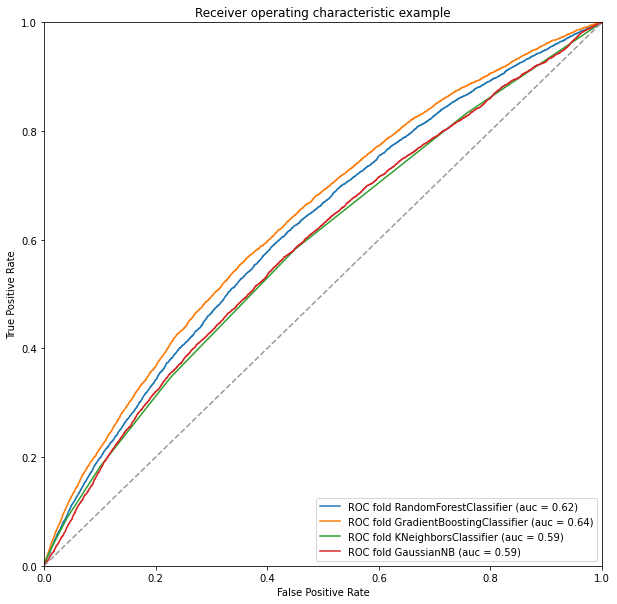

In [ ]:
pl.figure(figsize=(10, 10))
for model in models:
    model.fit(TRNtrain, TARtrain)
    pred_scr = model.predict_proba(TRNtest)[:, 1]
    fpr, tpr, thresholds = roc_curve(TARtest, pred_scr)
    roc_auc = ml_metrics.auc(TARtest, pred_scr)
    md = str(model)
    md = md[:md.find('(')]
    pl.plot(fpr, tpr, label='ROC fold %s (auc = %0.2f)' % (md, roc_auc))

pl.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
pl.xlim([0, 1])
pl.ylim([0, 1])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

## 2. CatBoosting на всём-всём-всём наборе данных

После лекции от Артема возникла идея использовать CatBoost на train без какой-либо предобработке данных - первый  успешный результат, скор на лидер борде 0.4967. Попытались в предобработку, как в пункте 1 - картина ухудшалась. Затем поигрались с параметрами CatBoost. Опытным путем выяснили, что оптимальное количество эпох - 2000.
Попытались применить OneHotEncoding, что документацией строго-настрого запрещено (об этом мы узнали после получения результатов), соответственно, скор понизился. От идеи отказались

### Библиотеки

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Columns fix

### Preprocessing

In [ ]:
data = pd.read_csv('./datasets/train.csv', index_col='reco_id_curr')
df = pd.DataFrame(data)

In [ ]:
features = df.columns
categorial = [
    'own_car_flag',
    'own_realty_flag',
    'income_type_name',
    'family_status_name',
    'housing_type_name',
    'type_of_occupation',
    'type_of_organization',]

numeric = list(set(features) - set(categorial))

# Это на случай проверки на все числовые данные, не включая категориальные
features = df.select_dtypes(include=[np.number]).columns.tolist()
numeric = list(set(features) - set(['target']))

In [ ]:
X = df[features].drop(columns=['target'])
y = df['target']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

abs_transformer = FunctionTransformer(np.abs, validate=False)

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('absolute', abs_transformer),
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric),
        # Разкомментировать для включения категориальных данных в обработку
        #('cat', categorical_transformer, categorial)
    ])

### Train

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                     random_state=0)

In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(iterations=2000,
                           task_type="GPU",
                           devices='0:1',
                           random_state = 2120)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
])

pipeline.fit(X_train, y_train)

In [ ]:
preds = pipeline.predict(X_valid)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = roc_curve(y_valid, preds)
plt.plot(fpr, tpr, label="test")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_valid, preds)

Gini=lr_auc*2 - 1
print(Gini)

In [ ]:
test = pd.read_csv('./datasets/test.csv')
preds = pipeline.predict(test[list(set(features)- set(['target']))])
preds = pd.DataFrame(preds, columns=['target'])
preds = preds.abs()

In [ ]:
ids = pd.DataFrame(test['reco_id_curr'])
ids.join(preds, how='outer').to_csv('answer.csv', index=False)

## 3. Грамотная обработка данных + CatBoost = успех

Здесь не будем приводить код, так как он не отличается от готового решения. Все изменения происходили с данными. То есть неудачные попытки данного раздела заключаются в работе нашего решения просто на других данных, которые похуже финальных. После того, как выбили максимальный для нас скор (не на финальных данных) - снова поигрались с параметрами CatBoost. Оптимальное количество эпох - 2000+- (мы взяли 2222), глубина по умолчанию.

# Готовое решение.

Команда Дора: Ольга Крылов, Данил Парков, Антон Чанчиков.
Представляем финальное решение, состоящее из следующих частей:
1. Обработка данных
В блоке обработки данных можно видеть, что мы анализируем все предоставленные в распоряжения таблицы. Каждая таблица предобрабатывается - удаляются ненужные стобцы, берется сумма или максимум поля (об этом подробнее на презентации). Каждую новую таблицу присоединяем к train и test.
2. CatBoost + 2000 итераций

Про работу: в целом мы работали как команда. Я и Даниил занимались кодом, самостоятельно проверяли разные гипотезы по выбору модели и работы с данными, пока Ольга занималась развернутым анализом. Затем запустили результаты от Ольги и сравнили с нашими, первый выдал лучший скор.

**Для корректной работы ноутбука необходимо иметь на диске в одной папке архив public_data.zip и test_csv. При необходимости, поменяйте пути в блоках кода номер 65 и 91.**

## Библиотеки

In [ ]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unzip '/content/drive/MyDrive/ShiftData/public_data.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/drive/MyDrive/ShiftData/public_data.zip
replace previous_loan.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Описание колонок.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bki.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bki_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace cash_pos_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace credit_card_balance.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace installments_payments.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import numpy as np
import random
random.seed(0)

In [ ]:
pd.set_option('display.max_columns', None) # Columns fix

## Подготовка данных

In [ ]:
df = pd.read_csv('/content/bki.csv')

In [ ]:
df = df[(df['credit_status'] == 'Active') | (df['credit_status'] == 'Sold')]

In [ ]:
df = df.groupby('reco_id_curr').agg({
    'reco_bureau_id': 'first',
    'credit_day_overdue': 'sum',
    'credit_sum_overdue': 'sum',
    'credit_sum_limit': 'sum',
    'credit_sum_debt': 'sum',
    'credit_sum': 'sum',
    'annuity_payment': 'sum',
    'days_credit_enddate': 'max',
    'days_enddate_fact': 'max',
    'days_credit_update': 'max',
    'credit_limit_max_overdue': 'sum'
}).assign(Prosrochka=lambda x: x['days_credit_enddate'] - x['days_enddate_fact'])

In [ ]:
df.to_csv('/content/bki_act_sum.csv')

In [ ]:
df = pd.read_csv('/content/bki.csv')

In [ ]:
df = df[df['credit_status'] == 'Closed']

In [ ]:
df = df.groupby('reco_id_curr').agg({
    'reco_bureau_id': 'first',
    'credit_day_overdue': 'sum',
    'credit_sum_overdue': 'sum',
    'credit_sum_limit': 'sum',
    'credit_sum_debt': 'sum',
    'credit_sum': 'sum',
    'annuity_payment': 'sum',
    'days_credit_enddate': 'max',
    'days_enddate_fact': 'max',
    'days_credit_update': 'max',
    'credit_limit_max_overdue': 'sum'
}).assign(Prosrochka=lambda x: x['days_credit_enddate'] - x['days_enddate_fact'])

In [ ]:
df.to_csv('/content/bki_closed_sum.csv')

In [ ]:
df = pd.read_csv('/content/cash_pos_balance.csv')

In [ ]:
df = df[df['contract_status_name'] == 'Active']

In [ ]:
df = df.groupby('reco_id_curr').agg({
    'installment_future_count': 'sum',
    'reco_dpd': 'sum',
    'months_balance': 'max',
    'installment_count': 'max',
    'reco_dpd_def': 'sum'
})

In [ ]:
df.to_csv('/content/cash_act.csv')

In [ ]:
df = pd.read_csv('/content/previous_loan.csv')

In [ ]:
df = df.groupby('reco_id_curr').agg({
    'last_day_app_f': 'first',
    'annuity_payment': 'sum',
    'termination_date': 'sum',
    'last_due_date': 'sum',
    'loan_body_requested': 'sum',
    'insured_last_f': 'sum',
    'days_first_due': 'sum',
    'first_due_date': 'sum',
    'payment_count': 'max',
    'contract_status_name': 'max'
})

In [ ]:
df.to_csv('/content/pr_loan_sum.csv')

In [ ]:
train = pd.read_csv('/content/train.csv')
df1 = pd.read_csv('/content/cash_act.csv')

In [ ]:
df = pd.merge(train, df, on='reco_id_curr', how='left')

In [ ]:
df = pd.merge(df, df1, on='reco_id_curr', how='left')

In [ ]:
df.to_csv('/content/train_new.csv')

In [ ]:
df2 = pd.read_csv('/content/bki_act_sum.csv')

In [ ]:
df = pd.merge(df, df2, on='reco_id_curr', how='left')
df = pd.merge(df, df1, on='reco_id_curr', how='left')

In [ ]:
df.to_csv('/content/train_new2.csv')

In [ ]:
data = df

In [ ]:
df = pd.read_csv('/content/pr_loan_sum.csv')
test = pd.read_csv('/content/drive/MyDrive/ShiftData/test.csv')
df1 = pd.read_csv('/content/cash_act.csv')
df = pd.merge(test, df, on='reco_id_curr', how='left')
df = pd.merge(df, df1, on='reco_id_curr', how='left')
df.to_csv('/content/test_new.csv')
df2 = pd.read_csv('/content/bki_act_sum.csv')
df = pd.merge(df, df2, on='reco_id_curr', how='left')
df = pd.merge(df, df1, on='reco_id_curr', how='left')
df.to_csv('/content/train_new2.csv')
test = df
del df

In [ ]:
X = pd.DataFrame(data)
y = X['target']

In [ ]:
#Выделяем нумерические и категориальные признаки
num_cols = X.select_dtypes(exclude=['object']).columns
cat_cols = list(set(X.columns) - set(num_cols))

#В пустых местах у категориальных признаков ставим константную строку 'none'
from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy="constant", fill_value="none")
cat_data = pd.DataFrame(cat_imputer.fit_transform(X[cat_cols]), columns=cat_cols)
cat_data['reco_id_curr'] = X.index.values
cat_data.set_index('reco_id_curr', inplace=True)

#Пустые места в нумерических заполняем нулями
num_data = X[num_cols].fillna(0)

#Объединяем полученные обработанные нумерические и категориальные даты в новый train
X = num_data.join(cat_data).drop(columns='target')

## Train

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.9, test_size=0.1,
                                                    random_state=0)

In [ ]:
from catboost import CatBoostRegressor, Pool
model = CatBoostRegressor(iterations=2000,
                           task_type="GPU",
                           devices='0:1:2',
                           random_state=2130)

In [ ]:
pool_train = Pool(X_train, y_train, cat_features=cat_cols)
model.fit(pool_train)

In [ ]:
preds = model.predict(X_valid)

In [ ]:
from sklearn.metrics import mean_absolute_error, roc_curve
mean_absolute_error(y_valid, preds)

0.13609802026538254

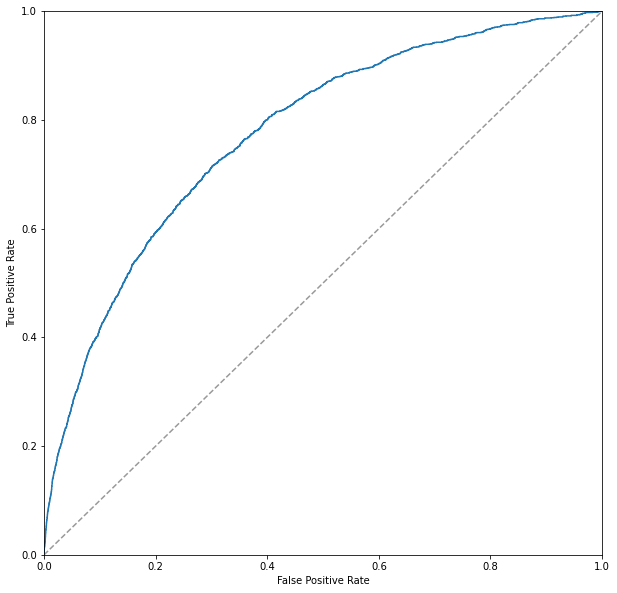

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
fpr, tpr, thresholds = roc_curve(y_valid, preds)
plt.plot(fpr, tpr, label="test")
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
lr_auc = roc_auc_score(y_valid, preds)
lr_auc

0.7750919162696228

In [ ]:
Gini=lr_auc*2 - 1 # 0.549508021050578
Gini

0.5501838325392456

In [ ]:
cat_data = pd.DataFrame(cat_imputer.fit_transform(test[cat_cols]), columns=cat_cols)
cat_data['reco_id_curr'] = test.index.values
cat_data.set_index('reco_id_curr', inplace=True)
num_data = test[list(set(num_cols)-set(['target']))].fillna(0)
test_data = num_data.join(cat_data)

In [ ]:
test_pool = Pool(test_data, cat_features=cat_cols)
test_preds = model.predict(test_pool)
results = pd.DataFrame({'reco_id_curr': test_data.index, 'target': test_preds})

In [ ]:
results.to_csv('answer.csv', index=False)

In [ ]:
results.shape

(46127, 2)

In [ ]:
results.head(15)

,reco_id_curr,target
0,0,0.059660
1,1,0.034910
2,2,0.068484
3,3,0.020771
4,4,0.026564
5,5,0.014635
6,6,0.031681
7,7,0.012000
8,8,0.163655
9,9,0.002321
